## 实验目的

## 实验简介

## 数据描述

## 主要任务

## 主要代码解释（代码结构，主要代码解释）

In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import shapefile
from pylab import mpl

In [5]:
sfArea = shapefile.Reader('data/范围/范围.shp')
sfPoint = shapefile.Reader('data/钻孔1/钻孔1_Project.shp')

In [17]:
#read index of points
features = sfPoint.shapeRecords()[:]
index = []
for feature in features:
    tmp = feature.shape.__geo_interface__['coordinates']
    index.append(tmp)
index = np.array(index)

#read labels of points and translate to int
labels = []
dic = {b'\xc8\xed\xc8\xf5\xcd\xc1':3, b'\xd6\xd0\xc8\xed\xcd\xc1':2, b'\xd6\xd0\xd3\xb2\xcd\xc1':1}
size = len(sfPoint.records())
rec = sfPoint.records()
for i in range(size):
    labels.append(dic[rec[i][3]])
labels = np.array(labels)

In [18]:
#create test data
x_min, x_max = index[:, 0].min() - 0.02, index[:, 0].max() + 0.05
y_min, y_max = index[:, 1].min() - 0.04, index[:, 1].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max,0.003),np.arange(y_min, y_max, 0.003))

In [23]:
#train model and predict
clf = SVC(C=100, gamma=10000)
clf.fit(index,labels)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

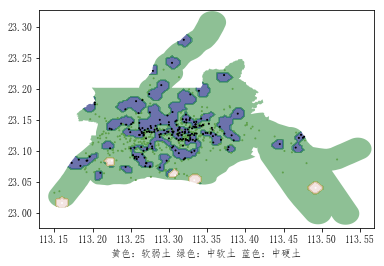

In [28]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
cont = plt.contourf(xx, yy, Z, cmap=plt.cm.gist_earth, alpha=0.60)
    
# Plot also the training points
plt.scatter(index[:, 0], index[:, 1], c=labels, cmap=plt.cm.gist_earth, s=1, alpha=2.5)

#translate the area to a path and clip
shape_rec = sfArea.shapeRecords()[-1]
vertices = []
codes = []
pts = shape_rec.shape.points
prt = list(shape_rec.shape.parts) + [len(pts)]
for i in range(len(prt) - 1):
    for j in range(prt[i], prt[i+1]):
        vertices.append((pts[j][0], pts[j][1]))
    codes += [Path.MOVETO]
    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
    codes += [Path.CLOSEPOLY]
clip = Path(vertices, codes)
clip = PathPatch(clip, transform=ax.transData, edgecolor='k')
for col in cont.collections:
    col.set_clip_path(clip)

#set the limit of x y
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
    
#set labels
mpl.rcParams['font.sans-serif'] = ['FangSong']
plt.xlabel("黄色：软弱土 绿色：中软土 蓝色：中硬土")

#save result and show figure
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('./result/result.eps', format='eps', dpi=1000)
figure_fig.savefig('./result/result.jpg', format='jpg', dpi=1000)
plt.show()

## 案例总结

## 操作练习

## 参考资料